In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from zimp.pos.statistics_analyzer import TextLengthAnalyzer
from zimp.pos.countvectorizer_analyzer import SymbolCountVectorizerAnalyzer
from glob import glob

plt.style.use('seaborn-whitegrid')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Martin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Martin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package perluniprops to
[nltk_data]     C:\Users\Martin\AppData\Roaming\nltk_data...
[nltk_data]   Package perluniprops is already up-to-date!


In [2]:
source_dir = '../../zimp_orchestrator/orch/resources'
files = {}
for ds_path in glob(source_dir + '/*'):
    if not os.path.isdir(ds_path):
        continue
    ds_name = os.path.basename(ds_path)
    files[ds_name] = [os.path.join(ds_path, 'train.csv'), os.path.join(ds_path, 'test.csv')]

In [3]:
def get_ds_stats(paths, analyzer_builder, track_name):
    texts = pd.read_csv(paths[0]).text.append(pd.read_csv(paths[1]).text)
    df =  analyzer_builder(texts).extract_dataset_metric().rename(columns={'count': track_name})
    return df

In [4]:
dfs = []
for dataset in files.keys():
    dfs.append(get_ds_stats(files[dataset], lambda texts: TextLengthAnalyzer(texts), dataset))
df = pd.concat(dfs, axis=1)
df_rel = df/df.sum(axis=0)
df_rel

,10K-GNAD,DBP-14,GERMEVAL-2018,GERMEVAL-2020,TREC-6,YELP-5
1,NaN,NaN,NaN,NaN,NaN,0.000023
2,NaN,NaN,NaN,NaN,NaN,0.000030
3,NaN,NaN,NaN,NaN,NaN,0.000043
4,NaN,NaN,NaN,NaN,NaN,0.000047
5,NaN,NaN,NaN,NaN,NaN,0.000064
...,...,...,...,...,...,...
18814,0.000097,NaN,NaN,NaN,NaN,NaN
18847,0.000097,NaN,NaN,NaN,NaN,NaN
19011,0.000097,NaN,NaN,NaN,NaN,NaN
22120,0.000097,NaN,NaN,NaN,NaN,NaN


In [15]:
def cropped_line_plot(df, allow_crop=True):
    
    if allow_crop and len(df.index) > 250:
        # remove all values above 95-percentile
        cs = df.sum(axis=1).cumsum()
        max_idx = min(max(cs[cs< cs.iloc[-1]*.95].idxmax(),200), df.index.max())
        df_plot = df[df.index <= max_idx]
        # resample to 100 equal-size intervals
        df_plot = df_plot.groupby(pd.cut(df_plot.index, 100))\
            .agg(lambda s: s.sum())\
            .rename(lambda idx: max(idx.left, 0))\
            .fillna(0)
    else:
        df_plot = df
    
    df_plot.plot(
        figsize=(10,5),
        color=plt.cm.jet(np.linspace(0, 1, len(df_plot.columns))),
        alpha=.5,
        title=f'Length of observations',
        xlabel='Number of characters',
        ylabel='Ratio'
    )
    
    plt.savefig(f'text_statistics/005_character_count.pdf')
    plt.show()

In [10]:
def violin_plot(df):
    
    if len(df.index) > 250:
        # remove all values above 98-percentile
        cs = df.sum(axis=1).cumsum()
        df_plot = df[cs< cs.iloc[-1]*.98]
    else:
        df_plot = df
        
    fig, axes = plt.subplots(figsize=(15,5))

    v_parts = axes.violinplot(dataset = [df_plot.index.repeat(df_plot[col].fillna(0)) for col in df_plot.columns], showmedians=True)

    colors=plt.cm.jet(np.linspace(0, 1, len(df.columns)))

    for partname in ('cbars','cmins','cmaxes','cmedians'):
        vp = v_parts[partname]
        vp.set_edgecolor('#000000')
        vp.set_linewidth(.5 if partname == 'cbars' else 1)
        vp.set_alpha(.5 if partname == 'cbars' else 1)

    # Make the violin body blue with a red border:
    for idx, vp in enumerate(v_parts['bodies']):
        vp.set_facecolor(colors[idx])
        vp.set_edgecolor(colors[idx])
        vp.set_linewidth(1)
        vp.set_alpha(0.5)

    axes.set_title(f'Text length for different datasets')
    axes.yaxis.grid(True)
    axes.set_xlabel('Dataset')
    axes.set_ylabel('Count of Characters')
    axes.set_xticks(np.arange(1, len(df_plot.columns) + 1), labels=df_plot.columns, fontsize=8)
    
    plt.savefig(f'text_statistics/005_violinplot_text_length.pdf')
    plt.show()

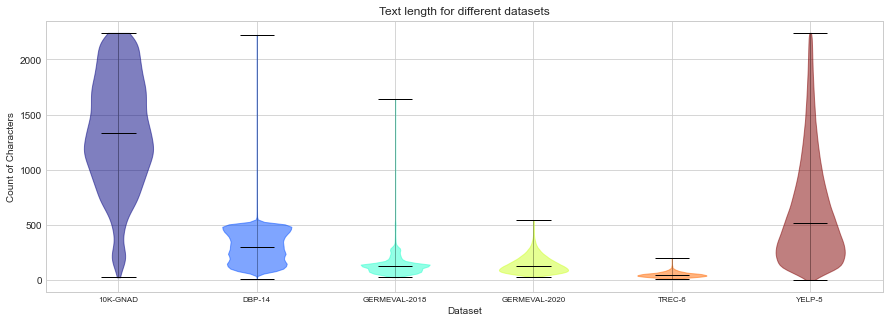

In [13]:
violin_plot(df)

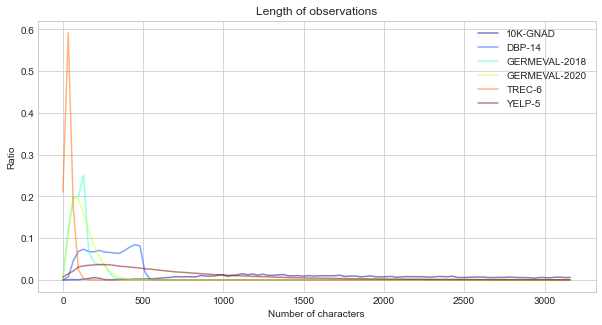

In [16]:
cropped_line_plot(df_rel)

### Symbol Analysis

In [18]:
dfs = []
for dataset in files.keys():
    dfs.append(get_ds_stats(files[dataset], lambda texts: SymbolCountVectorizerAnalyzer(texts, remove_whitespace=False), dataset+'_all'))
    dfs.append(get_ds_stats(files[dataset], lambda texts: SymbolCountVectorizerAnalyzer(texts, lowercase=True, only_alphabetic=True), dataset+'_alpha_lower'))
df = pd.concat(dfs, axis=1)

E:\Python\miniconda3\envs\zimp\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [42]:
df.to_csv('text_statistics/character_stats.csv')

In [48]:
df_all = df.loc[:, [col for col in df.columns if col.endswith('_all')]]
df_low = df.loc[:, [col for col in df.columns if not col.endswith('_all')]]

In [27]:
df_all.count()

10K-GNAD_all          378
DBP-14_all           7327
GERMEVAL-2018_all     344
GERMEVAL-2020_all     140
TREC-6_all             81
YELP-5_all             93
dtype: int64

In [39]:
vc = df_all['DBP-14_all'].value_counts()
vc.cumsum()/vc.sum()

1.0       0.224376
2.0       0.338338
3.0       0.406305
4.0       0.458441
5.0       0.496383
            ...   
291.0     0.999454
1953.0    0.999591
406.0     0.999727
2007.0    0.999864
3943.0    1.000000
Name: DBP-14_all, Length: 692, dtype: float64

In [40]:
df_low.count()

10K-GNAD_alpha_lower          219
DBP-14_alpha_lower           6462
GERMEVAL-2018_alpha_lower      44
GERMEVAL-2020_alpha_lower      48
TREC-6_alpha_lower             27
YELP-5_alpha_lower             26
dtype: int64

In [51]:
df_low.sum(axis=1).sort_values(ascending=False).head(n=40)

e    73236275.0
t    51570933.0
a    50042586.0
i    43800231.0
n    42078798.0
o    41700872.0
s    38082143.0
r    36130756.0
h    28538822.0
l    24646844.0
d    23836129.0
c    17498566.0
u    17285403.0
m    14371375.0
w    12765053.0
g    12512805.0
f    12353628.0
y    11404237.0
p    11175172.0
b    10356897.0
v     6592062.0
k     6128615.0
z     1487424.0
j     1240693.0
x     1032663.0
q      503317.0
ü      333791.0
ä      252975.0
ö      174680.0
ß       57571.0
é       38900.0
ā       37667.0
ó       28997.0
ا       27856.0
ˈ       23749.0
ł       21022.0
á       20113.0
а       18260.0
ī       16096.0
и       15939.0
dtype: float64